In [1]:
!pip install scikit-survival


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 12.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
!pip install optuna
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=d9a12df00d07e82c32236cf5d3c33c22f91067919cce2c6c60039fe6b48d102e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
!pip install pandas

# **This notebook aims to study interpretability methods for Survival ML**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Standard ML import
from sklearn.model_selection import train_test_split, cross_val_score
from sksurv.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import optuna

# Survival Analysis tools

from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored,cumulative_dynamic_auc,concordance_index_ipcw, integrated_brier_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sksurv.datasets import get_x_y

#from survlimepy import SurvLimeExplainer

# Interpretability tools

import shap
import lime
import lime.lime_tabular

# **Read and processing**

In [6]:
data_rea = pd.read_csv("readmission.csv")
data_rea.head()

,id,enum,t.start,t.stop,time,event,chemo,sex,dukes,charlson,death
0,1,1,0,24,24,1,Treated,Female,D,3,0
1,1,2,24,457,433,1,Treated,Female,D,0,0
2,1,3,457,1037,580,0,Treated,Female,D,0,0
3,2,1,0,489,489,1,NonTreated,Male,C,0,0
4,2,2,489,1182,693,0,NonTreated,Male,C,0,0


In [7]:
# Keep only the last admission for each patient
rea_trie = data_rea.sort_values(by=['id', 'enum'], ascending=[True, True])
rea_filtre = rea_trie.groupby('id').last().reset_index()

rea_filtre.head()

,id,enum,t.start,t.stop,time,event,chemo,sex,dukes,charlson,death
0,1,3,457,1037,580,0,Treated,Female,D,0,0
1,2,2,489,1182,693,0,NonTreated,Male,C,0,0
2,3,2,15,783,768,0,NonTreated,Male,C,3,1
3,4,5,686,2048,1362,0,Treated,Female,A-B,0,0
4,5,2,1134,1144,10,0,NonTreated,Female,C,3,0


In [8]:
# One-hot encoding
colonnes_categorielles = ['sex', 'chemo', 'dukes', 'charlson']
rea_filtre[colonnes_categorielles] = rea_filtre[colonnes_categorielles].astype('category')
encoder = OneHotEncoder()
encoder.fit(rea_filtre[colonnes_categorielles])
rea_encodees = encoder.transform(rea_filtre[colonnes_categorielles])
nouveaux_noms_colonnes = encoder.get_feature_names_out(colonnes_categorielles)
rea_encodees_df = pd.DataFrame(rea_encodees, columns=nouveaux_noms_colonnes)

# remove useless columns
rea_final = rea_filtre.drop(columns=colonnes_categorielles).join(rea_encodees_df)
rea_final = rea_final.drop(['id','t.start','t.stop'], axis = 1)

rea_final.head()

,enum,time,event,death,sex=Male,chemo=Treated,dukes=C,dukes=D,charlson=1-2,charlson=3
0,3,580,0,0,0.0,1.0,0.0,1.0,0.0,0.0
1,2,693,0,0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,768,0,1,1.0,0.0,1.0,0.0,0.0,1.0
3,5,1362,0,0,0.0,1.0,0.0,0.0,0.0,0.0
4,2,10,0,0,0.0,0.0,1.0,0.0,0.0,1.0


In [9]:
# Data split

X,y = get_x_y(rea_final,attr_labels=['death','time'],pos_label=1,survival=True)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.8,random_state=42)

# **Random Survival Forest**

In [ ]:
# Create and fit the random survival forest

rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, max_features="sqrt", n_jobs=-1, random_state=42)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                     random_state=42)

In [ ]:
# define the concordance index

c_index = concordance_index_censored(y_test['death'], y_test['time'], rsf.predict(X_test))
print("C-index:", c_index)

# define the concordance index ipcw

concordance_ipcw = concordance_index_ipcw(y_train, y_test, rsf.predict(X_test))
print(f"c_index_ipcw : {concordance_ipcw[0]}")

# compute the auc dynamic score

auc_dynamic = cumulative_dynamic_auc(y_train, y_test, rsf.predict(X_test),times = np.arange(1, 1945, 30))
print(f"auc_dynamic : {auc_dynamic[1]}")

#compute the ibs score
surv = rsf.predict_survival_function(X_test, return_array = True)
ibs = integrated_brier_score(y_train, y_test, surv, np.linspace(2, 2059, 63))
print("ibs:", ibs)

C-index: (0.7219260408084137, 14701, 5543, 389, 1057)
c_index_ipcw : 0.6709947477578925
auc_dynamic : 0.794132766957424
ibs: 0.2003865210949825


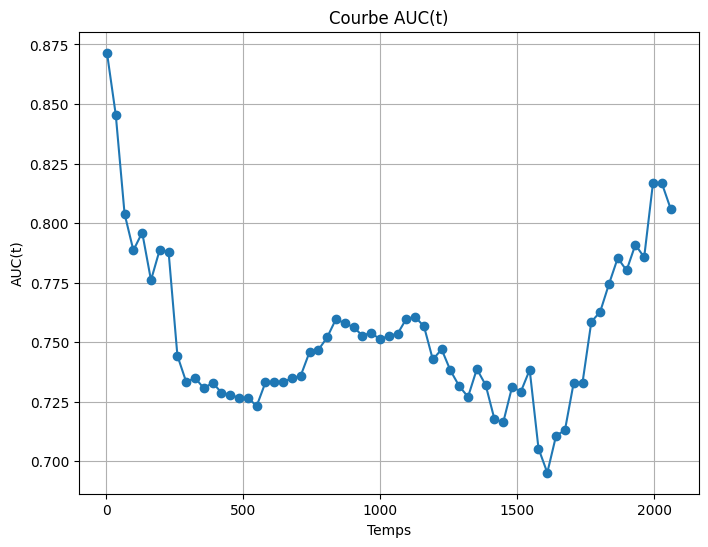

In [ ]:
#Plot
times = np.linspace(2, 2059, 65)
plt.figure(figsize=(8, 6))
plt.plot(times, auc_dynamic[0], marker='o', linestyle='-')
plt.xlabel('Temps')
plt.ylabel('AUC(t)')
plt.title('Courbe AUC(t)')
plt.grid(True)
plt.show()

In [ ]:
# Hyperparameters optimization with optuna

# We use the concordance index as evaluation metric
def scorer(estimator, X, y):
    concordance =  concordance_index_censored([elt[0] for elt in y],[elt[1] for elt in y],estimator.predict(X))[0]
    return concordance



def objective(trial):
    # Define search space for hyperparameters
    rsf_params = {
    'n_estimators' : trial.suggest_int('n_estimators', 50, 200),
    'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
    'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
    'max_features' : trial.suggest_categorical('max_features', ["sqrt", "log2"]),

    }

    # Initialize model with hyperparameters
    rsf2 = RandomSurvivalForest(**rsf_params, random_state=42)

    rsf2.fit(X_train , y_train)


    scores = concordance_index_censored(y_test['death'], y_test['time'], rsf2.predict(X_test) )
    c_index_mean = scores[0]

    return c_index_mean


# Create Optuna study object
study = optuna.create_study(direction='maximize')


# Run optimization
study.optimize(objective, n_trials=50)

# Access best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print("Best C-index:", study.best_value)

[I 2024-04-18 13:54:38,674] A new study created in memory with name: no-name-a6576f3a-2f62-4392-8b90-c89c1ca83dc0
[I 2024-04-18 13:54:38,893] Trial 0 finished with value: 0.8319197402219745 and parameters: {'n_estimators': 97, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8319197402219745.
[I 2024-04-18 13:54:39,215] Trial 1 finished with value: 0.8296903019434886 and parameters: {'n_estimators': 138, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8319197402219745.
[I 2024-04-18 13:54:39,524] Trial 2 finished with value: 0.8299326321911501 and parameters: {'n_estimators': 141, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8319197402219745.
[I 2024-04-18 13:54:39,866] Trial 3 finished with value: 0.826224979401929 and parameters: {'n_estimators': 141, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. 

Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best C-index: 0.8338826152280328


In [ ]:
# Hyperparameters optimization with a gridsearch approach, we use a gridsearch suggested by the optuna optimization

# Define the gridsearch space
param_grid = {
    'n_estimators': [69, 70, 71],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1,2],
    'max_features': ["sqrt", None]
}
# We use the concordance index as evaluation metric
def scorer(estimator, X, y):
    concordance =  concordance_index_censored([elt['death'] for elt in y],[elt['time'] for elt in y],estimator.predict(X))[0]
    return concordance

# Initialize the model
best_score = 0
best_params = None

for n_estimators in param_grid['n_estimators']:
    for min_samples_split in param_grid['min_samples_split']:
        for min_samples_leaf in param_grid['min_samples_leaf']:
          for max_features in param_grid['max_features']:
            # Create model instance with current hyperparameters
            model = RandomSurvivalForest(n_estimators= n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features= max_features, n_jobs=-1, random_state=42)

            def k_fold_cross_validation(model, X, y, k=5):
                """
                Performs k-fold cross-validation for a given model and dataset.

                Parameters:
                    model: The machine learning model to evaluate.
                    X (numpy.ndarray): The feature matrix.
                    y (numpy.ndarray): The target vector.
                    k (int): Number of folds for cross-validation.

                Returns:
                    float: The average accuracy across all folds.
                """
                n = len(X)
                fold_size = n // k
                scores = []

                for i in range(k):
                    # Splitting data into training and validation sets
                    validation_X = X[i * fold_size: (i + 1) * fold_size]
                    validation_y = y[i * fold_size: (i + 1) * fold_size]
                    train_X = np.concatenate([X[:i * fold_size], X[(i + 1) * fold_size:]])
                    train_y = np.concatenate([y[:i * fold_size], y[(i + 1) * fold_size:]])

                    # Fitting the model
                    model.fit(train_X, train_y)

                    # Making predictions on the validation set
                    y_pred = model.predict(validation_X)

                    # Calculating accuracy
                    score = scorer(model, validation_X, validation_y)
                    scores.append(score)

                # Returning the average accuracy
                return sum(scores) / k

            if k_fold_cross_validation(model, X_train, y_train, k=5)>best_score:
                best_score = k_fold_cross_validation(model, X_train, y_train, k=5)
                best_params = {'n_estimators': n_estimators, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature nam

Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best Score: 0.9070802712890533


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(


Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': '3', 'min_samples_leaf': '1', 'max_features': 'sqrt'}

Best Score: 0.8338826152280328

In [10]:
# Best RSF model

best_rsf = RandomSurvivalForest(n_estimators=70, min_samples_split=3, min_samples_leaf=1, max_features="sqrt", n_jobs=-1, random_state=42)
best_rsf.fit(X_train, y_train)

# Compute the concordance index
c_index = concordance_index_censored(y_test['death'], y_test['time'], best_rsf.predict(X_test))
print("C-index:", c_index)

C-index: (0.8338826152280328, 17000, 3222, 411, 1057)


In [ ]:
from sksurv.metrics import integrated_brier_score

In [ ]:
# define the concordance index

best_c_index = concordance_index_censored(y_test['death'], y_test['time'], best_rsf.predict(X_test))
print("C-index:", best_c_index)

# define the concordance index ipcw

best_concordance_ipcw = concordance_index_ipcw(y_train, y_test, best_rsf.predict(X_test))
print(f"c_index_ipcw : {best_concordance_ipcw[0]}")

# compute the auc dynamic score

best_auc_dynamic = cumulative_dynamic_auc(y_train, y_test, best_rsf.predict(X_test),times = np.arange(1, 1500, 30))
print(f"auc_dynamic : {best_auc_dynamic[1]}")

# compute the integrated brier score

best_surv = best_rsf.predict_survival_function(X_test, return_array = True)
times2 = np.linspace(2, 2059, 63)
best_ibs = integrated_brier_score(y_train, y_test, best_surv, times2)
print("ibs", best_ibs)


C-index: (0.8338826152280328, 17000, 3222, 411, 1057)
c_index_ipcw : 0.8014891900644371
auc_dynamic : 0.8680596672081078
ibs 0.14748426215093188


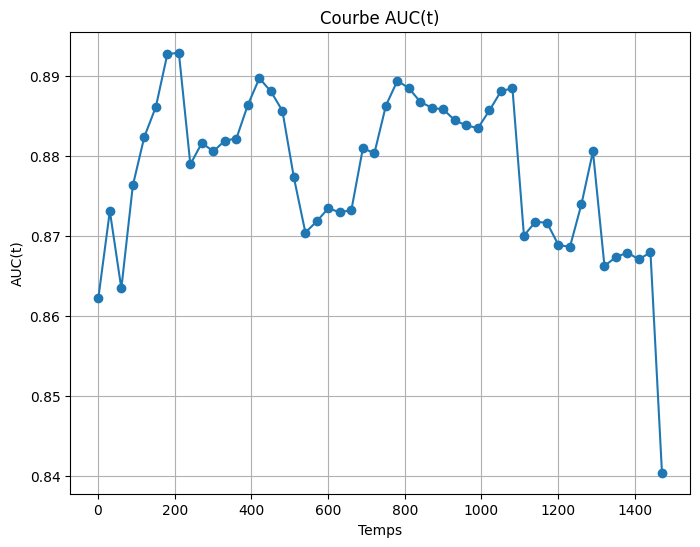

In [ ]:
#Auc(t) plot
#Plot
times3 = np.arange(1, 1500, 30)
plt.figure(figsize=(8, 6))
plt.plot(times3, best_auc_dynamic[0], marker='o', linestyle='-')
plt.xlabel('Temps')
plt.ylabel('AUC(t)')
plt.title('Courbe AUC(t)')
plt.grid(True)
plt.show()



In [ ]:
#number of people left in the study along time

def remaining(df):

  L = []
  for t in times3:
    remaining_count = (df['time'] > t).sum()  # Compter le nombre de personnes restantes
    L.append(remaining_count)
  return L

remaining (rea_final)


[319,
 307,
 295,
 288,
 284,
 277,
 272,
 269,
 255,
 253,
 248,
 245,
 242,
 239,
 234,
 232,
 229,
 228,
 221,
 217,
 212,
 210,
 209,
 206,
 203,
 200,
 193,
 190,
 187,
 183,
 180,
 178,
 173,
 170,
 165,
 162,
 153,
 144,
 136,
 128,
 124,
 119,
 114,
 105,
 95,
 84,
 78,
 75,
 72,
 60]

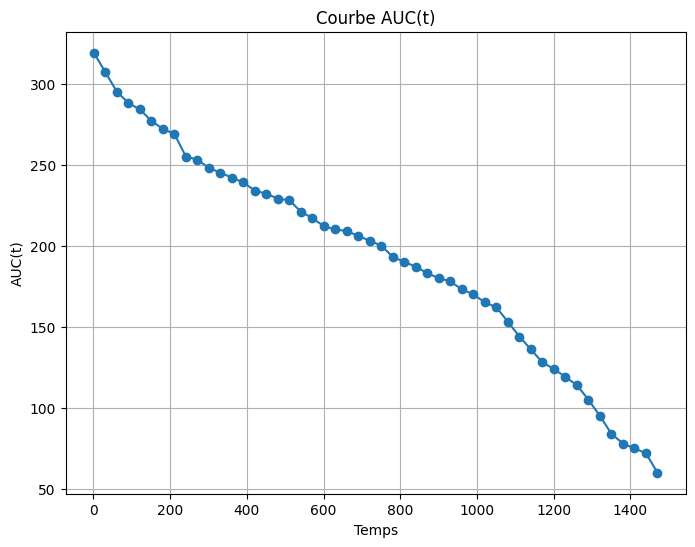

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(times3, remaining(rea_final), marker='o', linestyle='-')
plt.xlabel('Temps')
plt.ylabel('AUC(t)')
plt.title('Courbe AUC(t)')
plt.grid(True)
plt.show()

Passage de 320 à 60 environ : influence sur la courbe auc(t) sur les dernières valeurs

# **Interpretability methods**

# RVI

In [17]:
feature_importances = best_rsf.feature_importances_

total_importance = np.sum(feature_importances)
importances_percentage = (feature_importances / total_importance) * 100
importances_percentage.sort()
variable_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances_percentage)), importances_percentage, tick_label=variable_names)
plt.xlabel('Importance en pourcentage')
plt.ylabel('Variables')
plt.title('Importance des variables')
plt.show()

NotImplementedError: 

# LIME

In [11]:
!pip install survlimepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 39.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Attempting uninstall: scikit-survival
    Found existing installation: scikit-survival 0.22.2
    Uninstalling scikit-survival-0.22.2:
      Successfully uninstalled scikit-survival-0.22.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.2.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.2 which is incompatible.


In [12]:
import survlimepy

In [13]:
from survlimepy import SurvLimeExplainer
from survlimepy.load_datasets import Loader

In [16]:
explainer = SurvLimeExplainer(
    training_features=X_train,
    training_events=[tp[0] for tp in y_train],
    training_times=[tp[1] for tp in y_train],
    model_output_times=best_rsf.event_times_,
    random_state=42,
)

AttributeError: 'RandomSurvivalForest' object has no attribute 'event_times_'

In [ ]:
x_new = np.array([0.1,0.1])

explanation = explainer.explain_instance(
    data_row=x_new,
    predict_fn=best_rsf.predict_cumulative_hazard_function,
    num_samples=1000,
    verbose=False,
)

explainer.plot_weights()

ValueError: operands could not be broadcast together with shapes (1000,8) (1,2) 

Note to myself: find relevant samples to explain

# SHAP

In [ ]:
# Let's use shap method to interpret this model, since the output of a SSVM is a risk score, we can use classical shap method to interpret it

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(best_rsf.predict, X_train)
shap_values = explainer.shap_values(X_test)



  0%|          | 0/323 [00:00<?, ?it/s]

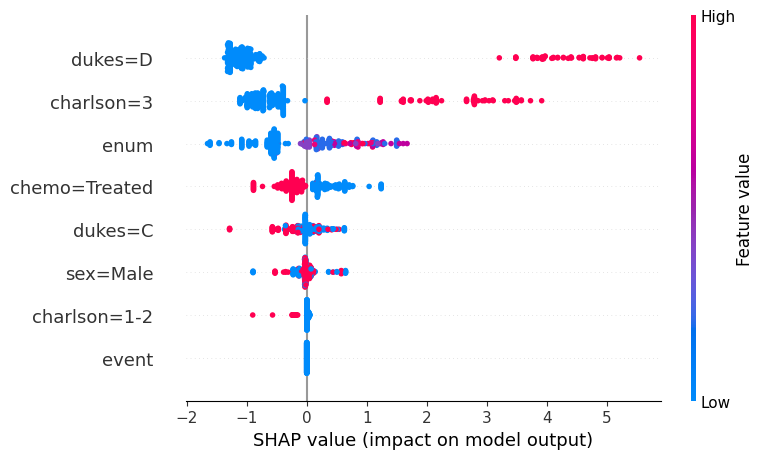

In [ ]:
shap.summary_plot(shap_values,X_test)